# Measurement Extraction of Pre-processed Filament

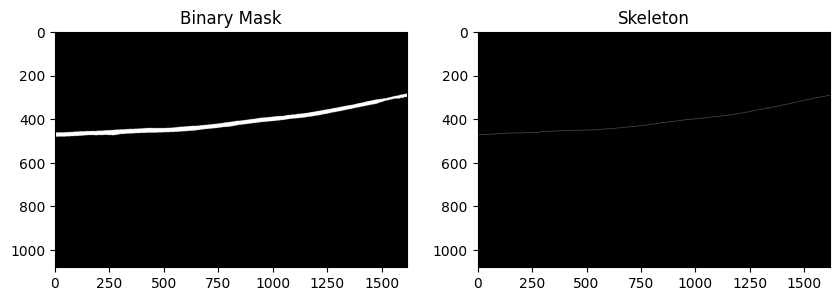

In [1]:
# Step 1: Skeleton Extraction
from skimage.morphology import skeletonize
import numpy as np
import cv2
import matplotlib.pyplot as plt

"""
Load the binary mask and compute the skeleton
"""

final_filament = r"F:\FILAMENT\images\processed_filament.jpg"
mask_gray = cv2.imread(final_filament, cv2.IMREAD_GRAYSCALE)

# Thresholding
_, binary = cv2.threshold(mask_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# MORPHOLOGICAL CLOSING: This fills the tiny black holes inside the filament
kernel = np.ones((5,5), np.uint8)
binary_cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

# Skeletonize (skimage needs boolean)
skeleton = skeletonize(binary_cleaned > 0)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Binary Mask")
plt.imshow(binary.astype(np.uint8) * 255, cmap="gray")
plt.subplot(1,2,2)
plt.title("Skeleton")
plt.imshow(skeleton.astype(np.uint8) * 255, cmap="gray")

plt.show()

In [2]:
# Step 2: Width Measurement
"""
Compute the distance transform and measure widths at skeleton points
"""
PIXEL_TO_CM = 0.012066083028912544

dist_transform = cv2.distanceTransform(binary_cleaned.astype(np.uint8), cv2.DIST_L2, 5)

coords = np.column_stack(np.where(skeleton)) 
coords = coords[coords[:, 1].argsort()] # Sort by column (X-axis)

# Get distances at these sorted coordinates
width_px = dist_transform[coords[:, 0], coords[:, 1]] * 2
width_cm = width_px * PIXEL_TO_CM

cm_to_pixel_ideal = 1.75 / width_px.mean()
print(f"Ideal Pixel-to-CM: {cm_to_pixel_ideal}")
print(f"Measured Widths (cm): {width_cm}")

# width statistics for overall quality of the filament
mean_width = np.mean(width_cm)
std_width = np.std(width_cm)
print(f"Mean Width: {mean_width:.2f} cm")
print(f"Width Std Dev: {std_width:.2f} cm")

# local width variation for bulge/neck detection
width_cm_smooth = np.convolve(width_cm, np.ones(5)/5, mode="valid")
local_mean = (width_cm_smooth[:-1] + width_cm_smooth[1:]) / 2
local_change = np.abs(np.diff(width_cm_smooth)) / local_mean
max_local_change = np.max(local_change)
print(f"Max Local Width Change: {max_local_change:.2%}")


Ideal Pixel-to-CM: 0.09248048067092896
Measured Widths (cm): [0.12066083 0.144793   0.16892517 ... 0.15904786 0.12066083 0.09652866]
Mean Width: 0.23 cm
Width Std Dev: 0.03 cm
Max Local Width Change: 13.00%


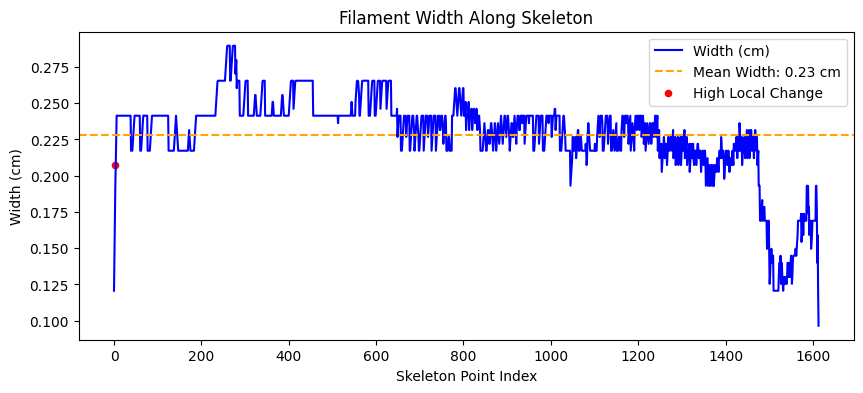

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Plot widths along skeleton
plt.figure(figsize=(10,4))
plt.plot(width_cm, label="Width (cm)", color='blue')
plt.axhline(mean_width, color='orange', linestyle='--', label=f"Mean Width: {mean_width:.2f} cm")

# Optional: highlight high local change regions
threshold = np.mean(width_cm_smooth) * 0.1  # example 10% change
# 1. Find where the change is high
high_change_idx = np.where(local_change > 0.1)[0]

# 2. Add the offset, but FILTER out any index that goes beyond the array size
valid_mask = (high_change_idx + 2) < len(width_cm_smooth)
plot_idx = high_change_idx[valid_mask] + 2

# 3. Plot using the safe indices
plt.scatter(plot_idx, width_cm_smooth[plot_idx], color='red', s=20, label="High Local Change")

plt.xlabel("Skeleton Point Index")
plt.ylabel("Width (cm)")
plt.title("Filament Width Along Skeleton")
plt.legend()
plt.show()


In [4]:
# Step 3: Straightness Analysis

"""
Compute deviations from the best-fit line along the skeleton
"""
coords1 = np.column_stack(np.where(skeleton))
mean = coords1.mean(axis=0)
U, S, Vt = np.linalg.svd(coords1 - mean, full_matrices=False)
# unit vector along the best-fit line
best_fit_direction = Vt[0]

coords_centered = coords1 - mean # center coordinates for distance calculation
dx, dy = best_fit_direction # unit vector components

# cross product of each skeleton point to the best-fit line (how far off the line it is)
distances_px = np.abs(
    coords_centered[:, 0] * dy -
    coords_centered[:, 1] * dx
)
print("distances:", distances_px)
distances_cm = distances_px * PIXEL_TO_CM
max_deviation = np.max(distances_cm)
mean_deviation = np.mean(distances_cm)
print(f"Mean Deviation from Straight Line: {mean_deviation:.2f} cm")
print(f"Max Deviation from Straight Line: {max_deviation:.2f} cm")


distances: [33.89931391 33.01319394 32.12707398 ... 20.92442936 19.9302815
 19.04416153]
Mean Deviation from Straight Line: 0.14 cm
Max Deviation from Straight Line: 0.41 cm


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

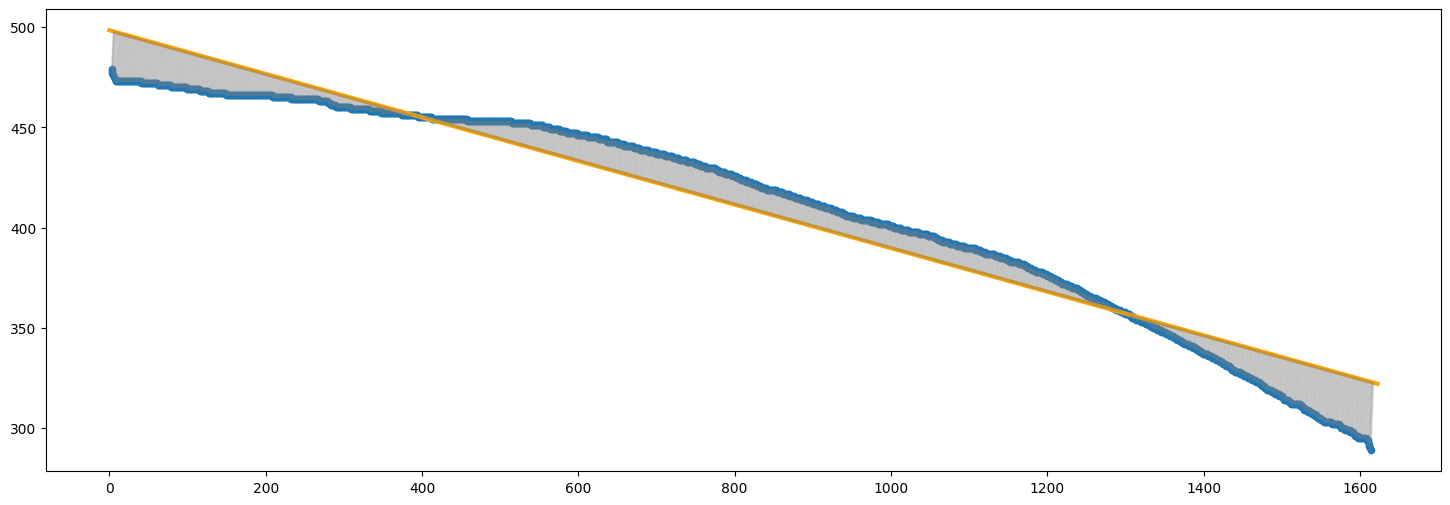

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ... (Your data variables: coords, mean, best_fit_direction, dx, dy, distances_cm, max_idx) ...

# 1. Setup the figure
# We use a wide layout to accommodate the long length, but 'auto' aspect will fill the height.
plt.figure(figsize=(18, 6), dpi=100) 

# ... (Calculations for projections/lines remain the same) ...
projections = ( (coords - mean) @ best_fit_direction )
t_min, t_max = projections.min() - 5, projections.max() + 5  
t = np.linspace(t_min, t_max, 200)
line_x = mean[1] + t * dy
line_y = mean[0] + t * dx

# 2. Plotting
plt.scatter(coords[:,1], coords[:,0], s=20, label="Skeleton Points")
plt.plot(line_x, line_y, color='orange', linewidth=3, label="Best-Fit Line") 

max_idx = max_deviation

# Draw deviations
for i in range(len(coords)):
    px, py = coords[i]
    proj_len = ( (px - mean[0])*dx + (py - mean[1])*dy )
    proj_x = mean[1] + proj_len * dy
    proj_y = mean[0] + proj_len * dx
    
    color = 'red' if i == max_idx else 'gray'
    alpha = 1.0 if i == max_idx else 0.3
    # Make the max deviation line thicker so it stands out
    lw = 3 if i == max_idx else 1 
    plt.plot([py, proj_x], [px, proj_y], color=color, alpha=alpha, linewidth=lw)

plt.scatter(coords[max_idx,1], coords[max_idx,0], color='red', s=100, zorder=5, label="Max Deviation")

# --- CRITICAL CHANGES HERE ---
plt.gca().invert_yaxis() 

# Changed from 'equal' to 'auto'. 
# This breaks physical geometry (angles won't look real) but makes vertical details visible.
plt.gca().set_aspect('auto') 

# Adding gridlines helps read the stretched values
plt.grid(True, linestyle='--', alpha=0.5)

plt.xlabel("X (pixels)", fontsize=12)
plt.ylabel("Y (pixels)", fontsize=12)
plt.title("Filament Skeleton (Stretched Y-Axis for Visibility)", fontsize=14)
plt.legend(fontsize=12)
plt.show()